## Imports

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats

from pathlib import Path

## Load Data and Inspect

In [117]:
pr_type_codes = {
  "1D": "Chapter 11 Bankruptcy Dismissed",
  "1F": "Chapter 11 Bankruptcy Filing",
  "1X": "Chapter 11 Bankruptcy Discharged",
  "2D": "Chapter 12 Bankruptcy Dismissed",
  "2F": "Chapter 12 Bankruptcy Filing",
  "2X": "Chapter 12 Bankruptcy Discharged",
  "3D": "Chapter 13 Bankruptcy Dismissed",
  "CJ": "Civil Judgment",
  "CP": "Child Support",
  "FC": "Foreclosure",
  "FT": "Federal Tax Lien",
  "JL": "Judicial Lien",
  "PC": "Paid Civil Jugment"
}

pr_source_type_codes = {
  "AS": "Associate Court",
  "BK": "U.S. Bankruptcy Court",
  "CA": "County Auditor",
  "CC": "County Clerk",
  "CI": "Circuit Court",
  "CL": "County Court at Law",
  "CN": "Conciliation Court",
  "CP": "Common Pleas",
  "CR": "County Recorder",
  "CT": "County Court",
  "CY": "City Court",
  "DC": "District Court",
  "FE": "Federal District",
  "JU": "Justice of the PeaceCourt type",
  "MA": "Magistrate Court",
  "MU": "Municipal Court",
  "PC": "Parish Court",
  "RD": "Recorder of Deeds",
  "SC": "Small Claims",
  "SU": "Superior Court"
}



In [118]:
pr = pd.read_csv('../Public_records.csv')

dtypes      = pr.dtypes
null_counts = pr.isna().sum()
distinct_obj = pr.select_dtypes(include="object").nunique(dropna=True)

print("Data Shape: ", pr.shape)


print(pd.concat({
    "dtype": dtypes,
    # "null_count": null_counts,
    "null_rate": round(100.0* null_counts / pr.shape[0]),
    "distinct_groups": distinct_obj
    },
    axis = 1
    ))

Data Shape:  (218303, 14)
                                     dtype  null_rate  distinct_groups
analytics_matchkey                   int64        0.0              NaN
industry_code_kind_of_business      object        0.0              2.0
reporting_subscriber_code           object        0.0           1535.0
public_record_type_code             object        0.0             23.0
effective_date_date_verified       float64        0.0              NaN
filed_date                           int64        0.0              NaN
paid_date                          float64       41.0              NaN
amount                             float64       28.0              NaN
public_record_source_type_code      object        0.0             20.0
equal_credit_opportunity_act_code   object        0.0              2.0
legislative_prohibited_code          int64        0.0              NaN
plaintiff_name                     float64      100.0              NaN
attorney_name                      float64      100

In [119]:
pr["public_record_type_desc"]   = pr["public_record_type_code"].map(pr_type_codes)
pr["public_record_source_desc"] = pr["public_record_source_type_code"].map(pr_source_type_codes)
pr.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number,public_record_type_desc,public_record_source_desc
0,1346747,ZP,99,CJ,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,NaN,NaN,Civil Judgment,Circuit Court
1,1346748,ZP,485,7X,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,NaN,NaN,NaN,Federal District
2,1346754,Z,11R,SL,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,NaN,NaN,NaN,Recorder of Deeds
3,1346754,ZP,1,7X,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,NaN,NaN,NaN,Federal District
4,1346756,ZP,1,RL,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,NaN,NaN,NaN,Recorder of Deeds


## Takeaways
- Inconsistent Date Typing needs to be addressed for dates
- Need to check Nulls. Final 3 columns are all null per data dictionary. (Maybe redacted for assignment?)
- There are 23 public record types in the data but only 13 in the data dictionary
- Reporting Subscriber Code is marked as "blank" in the data dictionary but has no nulls in the data 

## Fix DataTypes

### Date Formatting

In [120]:
for col in ["effective_date_date_verified", "filed_date", "paid_date"]:
    pr[col] = pd.to_datetime(pr[col], format='%Y%m%d', errors='coerce')

## Single Column Data Inconsistencies

### Date Ordering

In [121]:
cols  = ["filed_date", "effective_date_date_verified", "paid_date"]
codes = dict(zip(cols, "FEP"))


pr["order"] = pr.apply(
    lambda r: "".join(codes[c] for c in sorted([c for c in cols if pd.notna(r[c])],
                                               key=lambda x: r[x])),
    axis=1)

display(pr["order"].value_counts())



order
FPE    120534
FE      88611
FEP      8873
F         271
FP         14
Name: count, dtype: int64

### How long do people wait to pay

count    129421.000000
mean        380.077623
std         484.184294
min           0.000000
25%         100.000000
50%         139.000000
75%         461.000000
max        3793.000000
Name: filed_to_paid_days, dtype: float64


(0.0, 500.0)

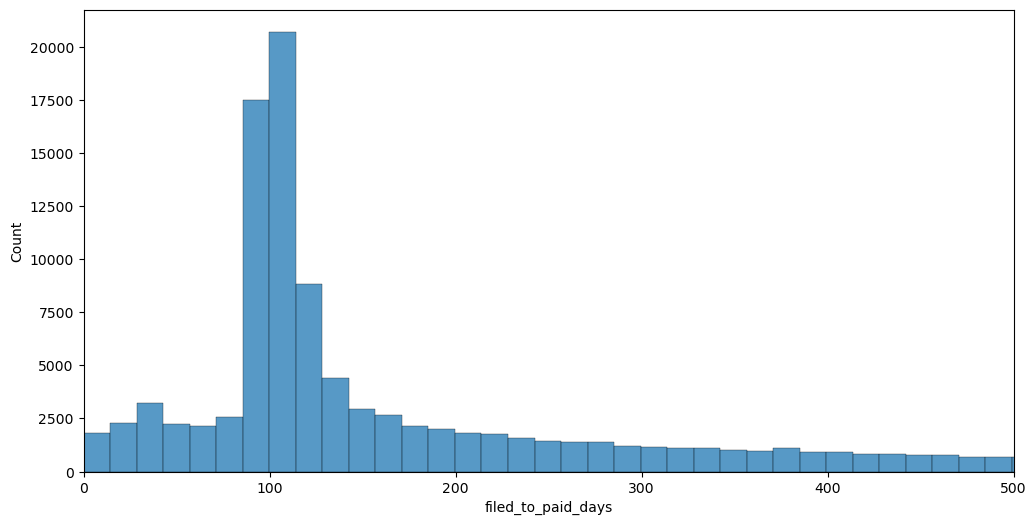

In [122]:
pr["filed_to_paid_days"] = (
    pr["paid_date"] - pr["filed_date"]).dt.days

print(pr["filed_to_paid_days"].describe())

fig = plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=pr,
    x='filed_to_paid_days',
)

ax.set_xlim(0,500)



### Amounts

Negative amounts: 0,  Zero amounts: 775


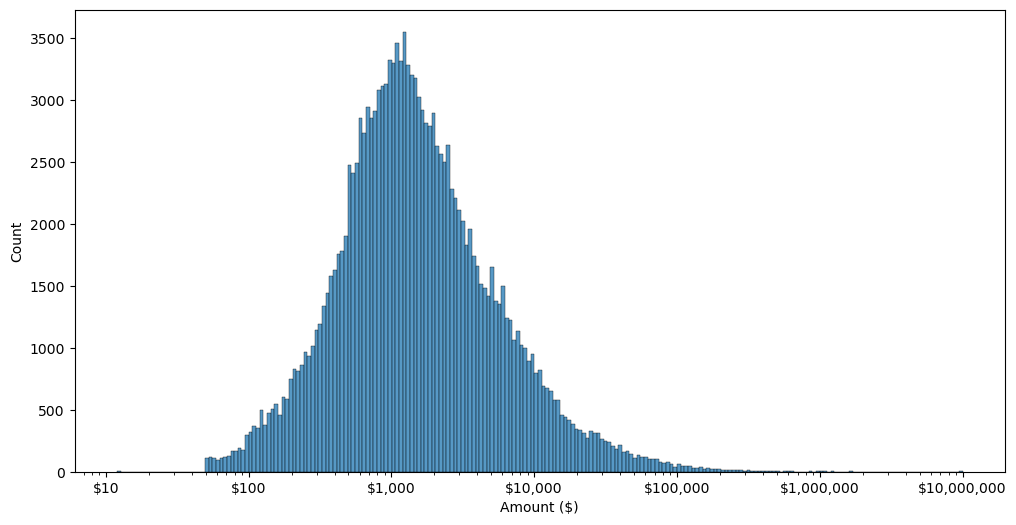

In [123]:
neg_amt  = pr[pr['amount'] < 0]
zero_amt = pr[pr['amount'] == 0]
print(f'Negative amounts: {len(neg_amt)},  Zero amounts: {len(zero_amt)}')

plot_df = pr.loc[pr['amount'] > 0].copy()

fig = plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=plot_df,
    x='amount',
    log_scale=True
)

ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
) # format tick labels as dollars
ax.set_xlabel('Amount ($)')
plt.show()

### Customer Claim Counts

In [124]:
pr_counts = pr.groupby('analytics_matchkey').size()
print(pr_counts.describe())

print("Percentage of Customers with more than one claim: ", (pr_counts > 1).mean())
print("Percentage of Customers with more than two claims: ", (pr_counts > 2).mean())

count    134717.000000
mean          1.620456
std           1.321797
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          87.000000
dtype: float64
Percentage of Customers with more than one claim:  0.328006116525754
Percentage of Customers with more than two claims:  0.13928457432989155


### Categorical Counts

/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

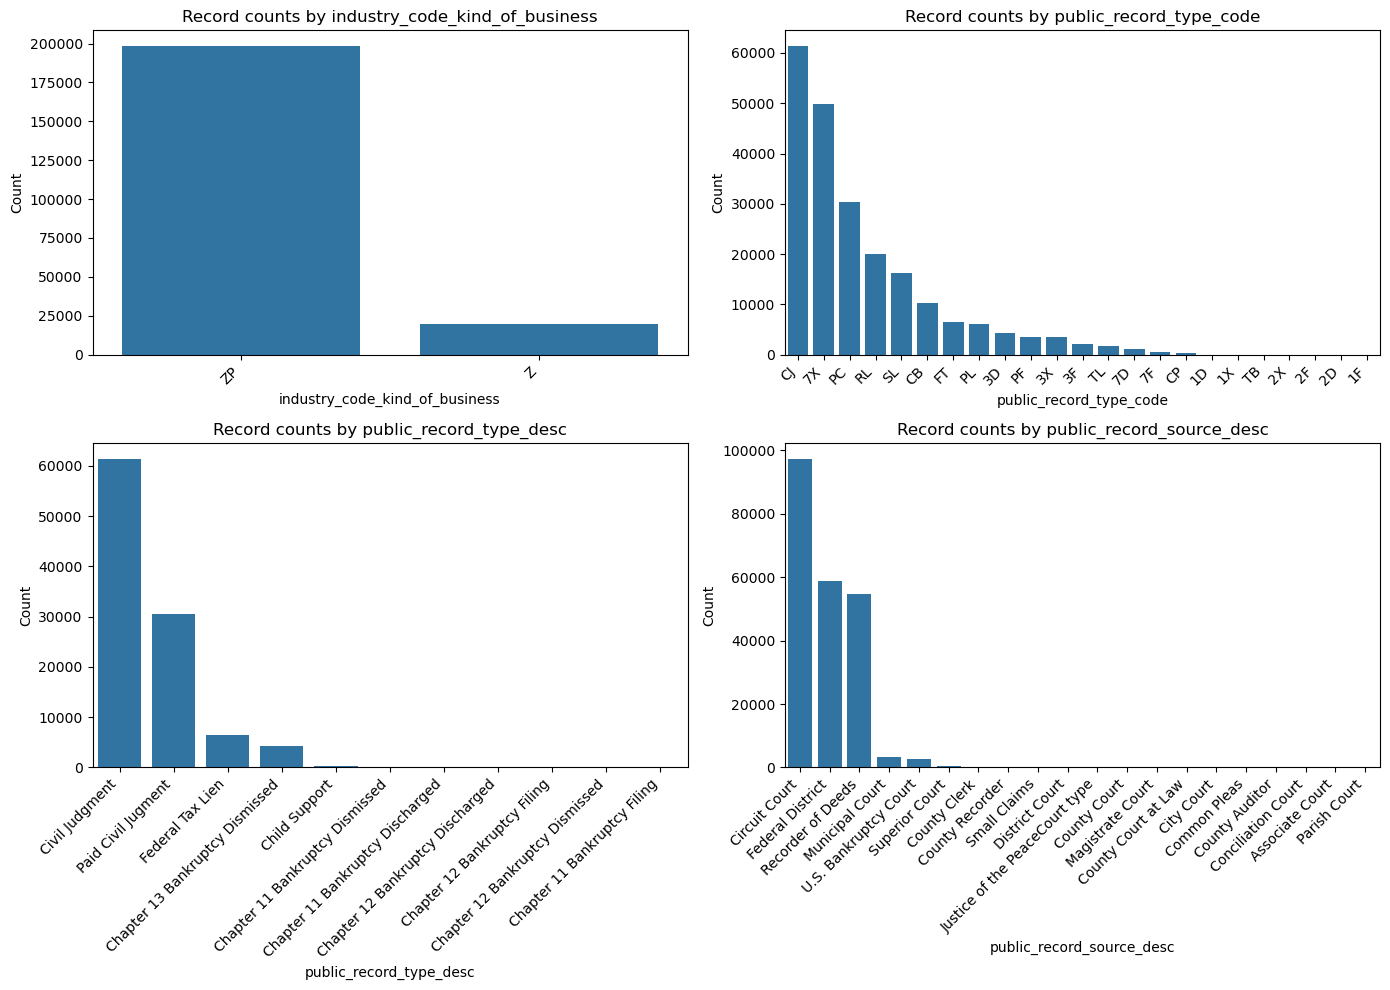

In [125]:
cats = ['industry_code_kind_of_business', 'public_record_type_code', 'public_record_type_desc', 'public_record_source_desc']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    counts = pr[cat].value_counts(dropna=False)
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(f"Record counts by {cat}")
    ax.set_xlabel(cat)
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Takeaways
#### Date ordering
- Filed Date ALWAYS Comes First. This makes sense as we wouldnt have data on this unless the claim was filed
- Usually, the debt is paid and then the Reporting org (which in this context would be a bank or court...) will recognize it in their public record system
- Interestingly we have many records of F-E which indicates that the court does not necesarily wait till payment to record the record. It is worth looking at how long they will wait
- There is then a smaller category of "F-E-P" Which could be late payments after the record is made. Will investigate
- F and F-P are interesting because the bank has not "took cognizence" of the record in its files, but we have it here. In this case, somethign must be wrong

#### Payment Speed
- Something happens around day 100 that results in many of these amounts being paid. 

#### Payment Amounts
- Data is Log-Normal
- Would expect this to change depending on claim type. Need to check
- Apparent (almost) hard cutoff at 70 dollars with a few low stragelers. This is weird.
- Why are there 700 0 claims? 

#### Customer Identifier
- Most Customers have only one claim. 32% have 2 or more, 13% have 3 or more

## CrossChecking
Do the diferences above get explained by any other variables

### Claim Amount Distributions by Categorical Variables

- Distribution Eye-check
- Kruskal-Wallis NonMarametric test (Nonparametric equivalent of ANOVA) 
*https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test*

Kruskal-Wallis for industry_code_kind_of_business: H = 0.469, p = 0.494
  → skipping level 'Chapter 13 Bankruptcy Dismissed' (only 0 samples)
Kruskal-Wallis for public_record_type_desc: H = 16475.997, p = 0.000
  → skipping level 'Federal District' (only 0 samples)
  → skipping level 'U.S. Bankruptcy Court' (only 0 samples)
Kruskal-Wallis for public_record_source_desc: H = 370.404, p = 0.000
Kruskal-Wallis for equal_credit_opportunity_act_code: H = 30.580, p = 0.000


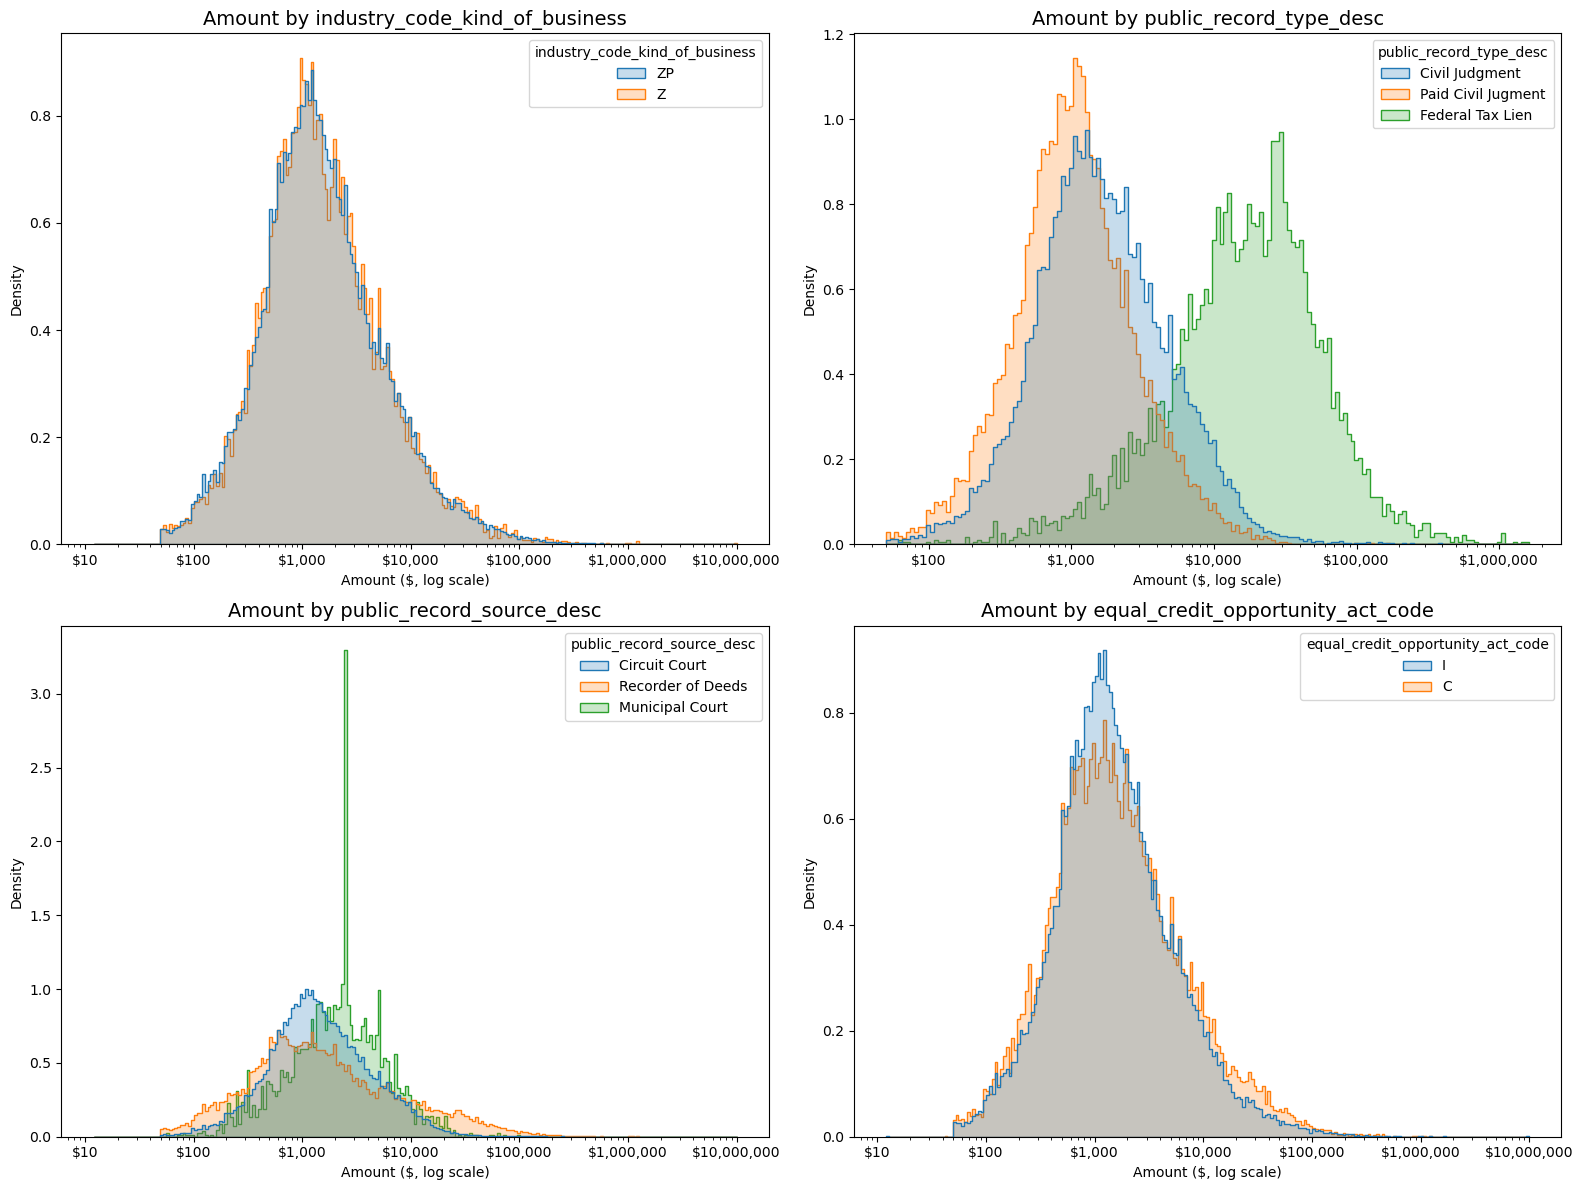

In [126]:
MIN_COUNT = 500

cats = ['industry_code_kind_of_business', 'public_record_type_desc', 'public_record_source_desc', 'equal_credit_opportunity_act_code']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    lvl_counts = pr[cat].value_counts()
    valid_lvls = lvl_counts[lvl_counts >= MIN_COUNT].index.tolist()

    # Subset DataFrame
    df_sub = pr[pr[cat].isin(valid_lvls)].copy()
    df_sub = df_sub[df_sub['amount'] > 0].copy()
    df_sub['log_amount'] = np.log(df_sub['amount'])
    

    # Check if there are enough valid levels
    groups = []
    for lvl in valid_lvls:
        grp = df_sub.loc[df_sub[cat] == lvl, 'log_amount']
        if len(grp) >= 2:
            groups.append(grp.values)
        else:
            print(f"  → skipping level {lvl!r} (only {len(grp)} samples)")
    
   # KW test if more than two groups. 
    if len(groups) >= 2:
        h_stat, p_val = stats.kruskal(*groups)
        print(f"Kruskal-Wallis for {cat}: H = {h_stat:.3f}, p = {p_val:.3f}")
    else:
        print(f"Not enough valid groups for Kruskal-Wallis on {cat}")

    
    # Plot histogram with hue
    sns.histplot(
        data=df_sub,
        x="amount",
        hue=cat,
        element="step",
        stat="density",
        common_norm=False,
        ax=ax,
        log_scale=True,
    )
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
    )
    
    ax.set_title(f"Amount by {cat}", fontsize=14)
    ax.set_xlabel("Amount ($, log scale)")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### Does Claim amount change by claim *number* for a given group

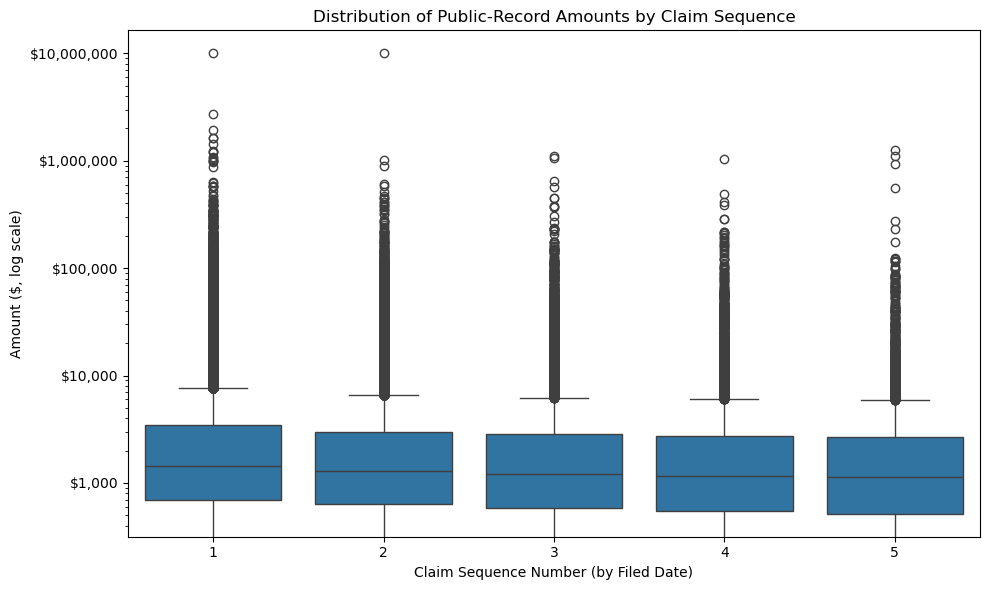

In [127]:
pr_sorted = pr.sort_values(['analytics_matchkey', 'filed_date'])
pr_sorted['claim_num'] = pr_sorted.groupby('analytics_matchkey').cumcount() + 1

df5 = pr_sorted[pr_sorted['claim_num'] <= 5].copy()
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df5, x='claim_num', y='amount', ax=ax)

# Log‐scale the y‐axis for skew
ax.set_yscale('log')

# Format y‐axis ticks as dollars
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
)

ax.set_xlabel('Claim Sequence Number (by Filed Date)')
ax.set_ylabel('Amount ($, log scale)')
ax.set_title('Distribution of Public-Record Amounts by Claim Sequence')
plt.tight_layout()
plt.show()

### Does the time to pay back a loan vary by any of our categorical variables

Kruskal-Wallis for industry_code_kind_of_business: H = 1010.930, p = 0.000
Kruskal-Wallis for public_record_type_desc: H = 8.876, p = 0.031
Kruskal-Wallis for public_record_source_desc: H = 17185.881, p = 0.000
Kruskal-Wallis for equal_credit_opportunity_act_code: H = 255.207, p = 0.000


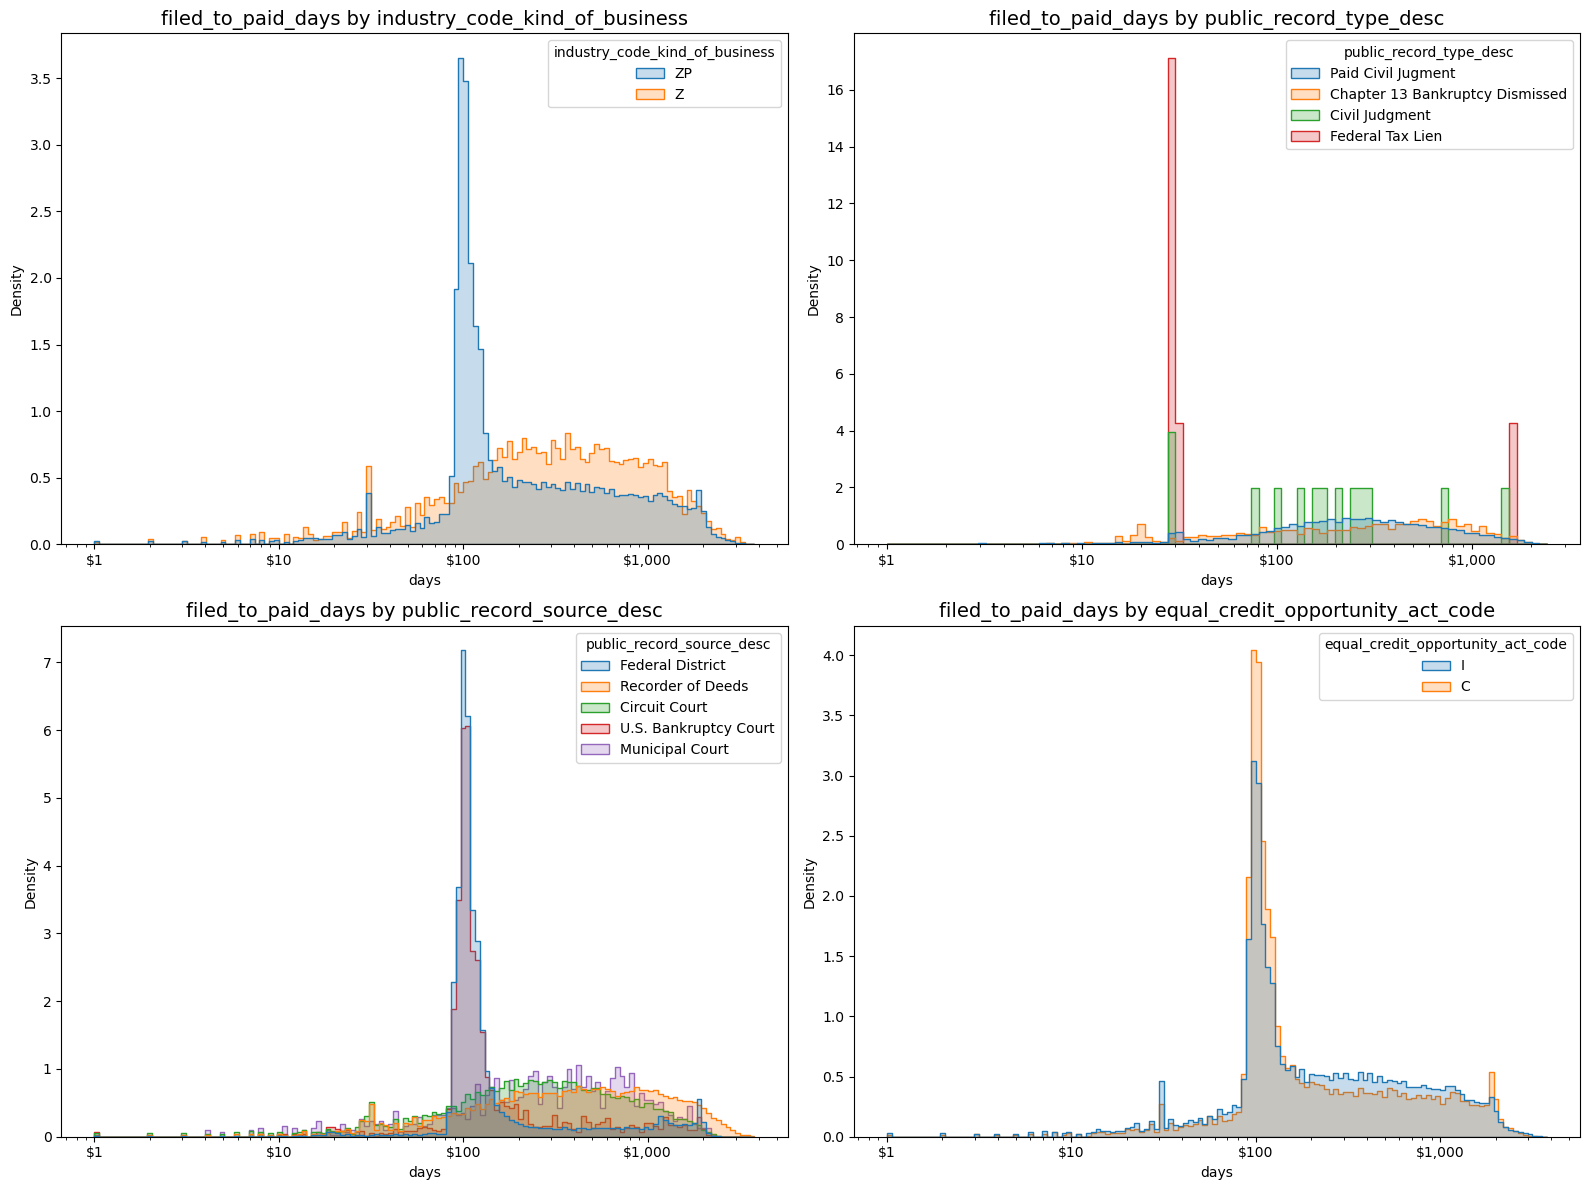

In [128]:
MIN_COUNT = 500

cats = ['industry_code_kind_of_business', 'public_record_type_desc', 'public_record_source_desc', 'equal_credit_opportunity_act_code']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    lvl_counts = pr[cat].value_counts()
    valid_lvls = lvl_counts[lvl_counts >= MIN_COUNT].index.tolist()

    # Subset DataFrame
    df_sub = pr[pr[cat].isin(valid_lvls)].copy()
    df_sub = df_sub[df_sub['filed_to_paid_days'] > 0].copy()
    

    # Check if there are enough valid levels
    groups = []
    for lvl in valid_lvls:
        grp = df_sub.loc[df_sub[cat] == lvl, 'filed_to_paid_days']
        if len(grp) >= 2:
            groups.append(grp.values)
        else:
            print(f"  → skipping level {lvl!r} (only {len(grp)} samples)")
    
   # KW test if more than one groups. 
    if len(groups) >= 2:
        h_stat, p_val = stats.kruskal(*groups)
        print(f"Kruskal-Wallis for {cat}: H = {h_stat:.3f}, p = {p_val:.3f}")
    else:
        print(f"Not enough valid groups for Kruskal-Wallis on {cat}")

    
    # Plot histogram with hue
    sns.histplot(
        data=df_sub,
        x="filed_to_paid_days",
        hue=cat,
        element="step",
        stat="density",
        common_norm=False,
        ax=ax,
        log_scale=True,
    )
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
    )
    
    ax.set_title(f"filed_to_paid_days by {cat}", fontsize=14)
    ax.set_xlabel("days")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### Does Loan amount affect how quickly it is paid (When it is paid)

Check Correlation and plot lowess curve to controll for fanning 

*https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html*

/opt/anaconda3/envs/loan_performance/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


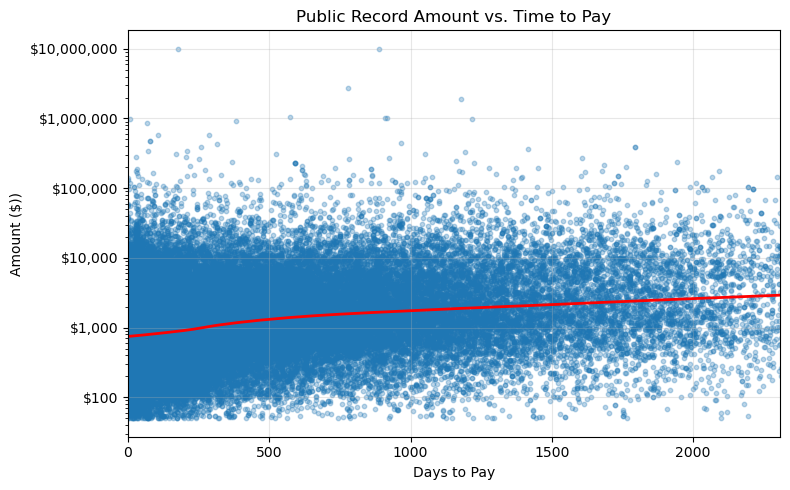

Pearson (days, log-amount) = 0.265 (p = 0)


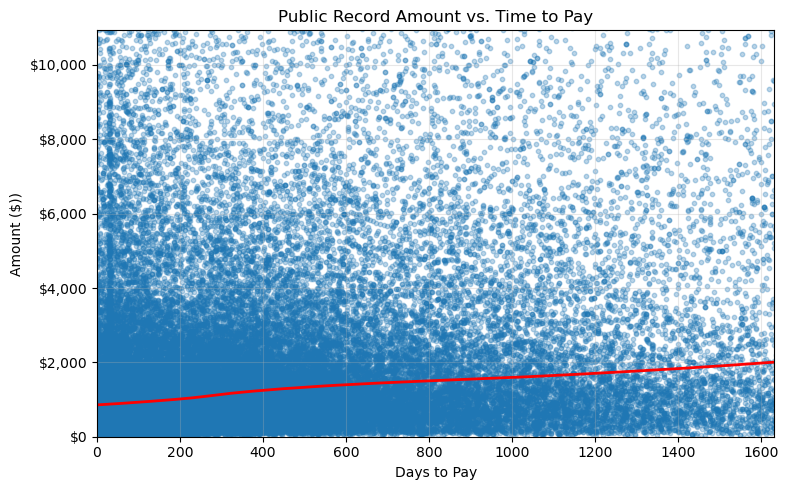

In [134]:
df_pay = pr.dropna(subset=['filed_date','paid_date','amount']).copy()
df_pay = df_pay[df_pay['paid_date'] >= df_pay['filed_date']]
df_pay = df_pay[df_pay['amount'] > 0]


lowess = sm.nonparametric.lowess
x = pr['filed_to_paid_days']
y = np.log(pr['amount'])
smoothed = lowess(y, x)  


plt.figure(figsize=(8,5))
plt.scatter(df_pay['filed_to_paid_days'], df_pay['amount'], alpha=0.3, s=10)

plt.plot(smoothed[:,0], np.exp(smoothed[:,1]), 'r-', lw=2)

plt.xlim(0, df_pay['filed_to_paid_days'].quantile(0.99))  # zoom in on the 99th percentile for clarity
plt.yscale('log')
plt.xlabel('Days to Pay')
plt.ylabel('Amount ($))')
plt.title('Public Record Amount vs. Time to Pay')
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
pearson_r, pearson_p = stats.pearsonr(df_pay['filed_to_paid_days'], np.log(df_pay['amount']))

print(f"Pearson (days, log-amount) = {pearson_r:.3f} (p = {pearson_p:.3g})")


lowess = sm.nonparametric.lowess
x = pr['filed_to_paid_days']
y = pr['amount']
smoothed = lowess(y, x)  


plt.figure(figsize=(8,5))
plt.scatter(df_pay['filed_to_paid_days'], df_pay['amount'], alpha=0.3, s=10)

plt.plot(smoothed[:,0], smoothed[:,1], 'r-', lw=2)

plt.xlim(0, df_pay['filed_to_paid_days'].quantile(0.95))  # zoom in on the 99th percentile for clarity
plt.ylim(0, df_pay['amount'].quantile(0.95))  # zoom in on the 99th percentile for clarity
plt.xlabel('Days to Pay')
plt.ylabel('Amount ($))')
plt.title('Public Record Amount vs. Time to Pay')
plt.gca().yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### What Drives whether the amount has been paid back or not? 

In [131]:
obj_cols = pr.select_dtypes(include='object').columns.tolist()
print(obj_cols)

['industry_code_kind_of_business', 'reporting_subscriber_code', 'public_record_type_code', 'public_record_source_type_code', 'equal_credit_opportunity_act_code', 'public_record_type_desc', 'public_record_source_desc', 'order']


Total unpaid records: 86,053 of 156,017 (55.2%)

--- Unpaid by industry_code_kind_of_business ---


,unpaid_count,total_count,unpaid_pct
industry_code_kind_of_business,,,
ZP,75430,136306,0.553387
Z,10623,19711,0.538938




--- Unpaid by public_record_type_code ---


,unpaid_count,total_count,unpaid_pct
public_record_type_code,,,
CJ,61412.0,61425,0.999788
SL,16088.0,16096,0.999503
FT,6505.0,6511,0.999078
TL,1764.0,1764,1.000000
CP,249.0,249,1.000000
CB,26.0,10266,0.002533
TB,9.0,9,1.000000
PC,0.0,29879,0.000000
RL,0.0,20057,0.000000




--- Unpaid by public_record_type_desc ---


,unpaid_count,total_count,unpaid_pct
public_record_type_desc,,,
Civil Judgment,61412.0,61425,0.999788
Federal Tax Lien,6505.0,6511,0.999078
Child Support,249.0,249,1.000000
Paid Civil Jugment,0.0,29879,0.000000




--- Unpaid by public_record_source_type_code ---


,unpaid_count,total_count,unpaid_pct
public_record_source_type_code,,,
CI,58329.0,96823,0.602429
RD,24887.0,54508,0.456575
MU,2083.0,3291,0.632938
SU,363.0,486,0.746914
CC,109.0,216,0.504630
DC,65.0,146,0.445205
SC,62.0,163,0.380368
CR,49.0,195,0.251282
CT,35.0,49,0.714286




--- Unpaid by public_record_source_desc ---


,unpaid_count,total_count,unpaid_pct
public_record_source_desc,,,
Circuit Court,58329.0,96823,0.602429
Recorder of Deeds,24887.0,54508,0.456575
Municipal Court,2083.0,3291,0.632938
Superior Court,363.0,486,0.746914
County Clerk,109.0,216,0.504630
District Court,65.0,146,0.445205
Small Claims,62.0,163,0.380368
County Recorder,49.0,195,0.251282
County Court,35.0,49,0.714286




--- Unpaid by equal_credit_opportunity_act_code ---


,unpaid_count,total_count,unpaid_pct
equal_credit_opportunity_act_code,,,
I,67772,119742,0.565984
C,18281,36275,0.503956


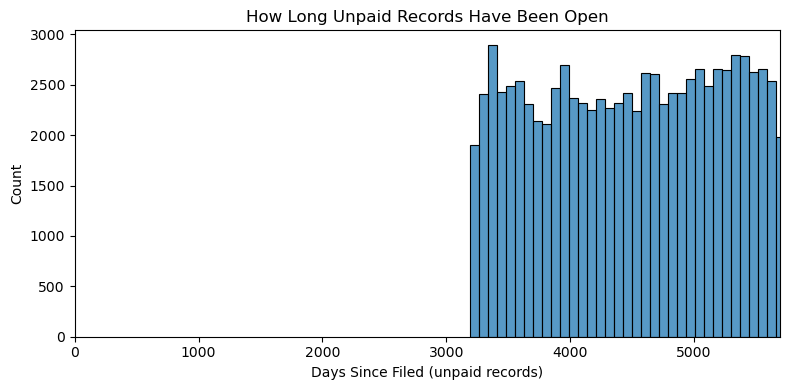

In [136]:
pr_pos = pr[pr['amount'] > 0].copy()

# 2) unpaid among those
unpaid = pr_pos[pr_pos['paid_date'].isna()].copy()
print(f"Total unpaid records: {len(unpaid):,} of {len(pr_pos):,} "
      f"({len(unpaid)/len(pr_pos):.1%})\n")

cats2 = ['industry_code_kind_of_business',  
         'public_record_type_code',
         'public_record_type_desc',  
         'public_record_source_type_code', 
         'public_record_source_desc', 
         'equal_credit_opportunity_act_code',
         ]

# 3) loop over categories
for cat in cats2:
    vc_unpaid = unpaid[cat].value_counts().rename("unpaid_count")
    vc_total  = pr_pos[cat].value_counts().rename("total_count")

    df = (
        pd.concat([vc_unpaid, vc_total], axis=1)
          .fillna(0)
          .assign(unpaid_pct=lambda d: d.unpaid_count / d.total_count)
          .sort_values('unpaid_count', ascending=False)
    )
    
    print(f"--- Unpaid by {cat} ---")
    display(df.head(10))
    print("\n")

# 4) how long they’ve been open
today = pd.Timestamp.today()
unpaid['filed_dt']   = pd.to_datetime(unpaid['filed_date'], format='%Y%m%d', errors='coerce')
unpaid['days_open']  = (today - unpaid['filed_dt']).dt.days

plt.figure(figsize=(8,4))
sns.histplot(unpaid['days_open'], bins=50, kde=False)
plt.xlim(0, unpaid['days_open'].quantile(0.99))
plt.xlabel("Days Since Filed (unpaid records)")
plt.title("How Long Unpaid Records Have Been Open")
plt.tight_layout()
plt.show()

### Takeaways
#### Overall
- These Records are not independant. The right way to treat this data is to view it as a story for each analytics_matchkey. Not as individual filings. 

#### Payment Amount
- The Public record type and source do drive different "distributions" of payment amount. This makes sense.
- The Equal opertunity act indicator also is statistiacally signifficantly different (by kruskal wallis), but the effect does not appear large enough to matter to us. 

- Claim Amount does not change by claim number for each analtyic_matchkey. There is no  clear "debt spiral" or worsening condition as I had theorized
- Correlation between log_amount and days to pay is only .2. It does not appear that people take longer to pay back larger loans

#### Payment Speed
- Whether the loan has been paid back actualy appears to be due largly to the public_record_type_desc. Civil Judgements (99%), Tax Liens(99%) and Child support (88%) are all majority unpaid while the other categories are majority paid. This raises the question of why? 
- It is interesting that Public record type drives the payment question so strongly but Public record source does not. I would have assumed these things were more heavily related
- Unpaid records don thave a signifficant time trend. I expected that maybe more recent records would be upaid more than older records